In [28]:
using Pkg

Pkg.add("Graphs")
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("HiGHS")
Pkg.add("EAGO")
Pkg.add("BenchmarkTools")
Pkg.add("Distances")
Pkg.add("Plots")
ENV["GUROBI_HOME"] = "/Library/gurobi952/macos_universal2/"
Pkg.add("Gurobi")
Pkg.build("Gurobi")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Ch

In [1]:
struct Delivery
    x::Float64
    y::Float64
end;
function random_delivery()
    x = rand(0.0:0.1:100.0)
    y = rand(0.0:0.1:100.0)
    return Delivery(x, y)
end;

struct TSProblem
    deliveries::Array{Delivery}
end;

function random_instance(n_deliveries)
    deliveries = [random_delivery() for _=1:n_deliveries]
    problem = TSProblem(deliveries)
    return problem
end;

function dist(del1::Delivery, del2::Delivery)
    return sqrt((del1.x - del2.x)^2 + (del1.y - del2.y)^2)
end
function calc_travelmatrix(deliveries::Array{Delivery})
    tm = zeros(Float64, length(deliveries), length(deliveries))
    for i = 1:length(deliveries)
        for j = 1:length(deliveries)
            tm[i, j] = dist(deliveries[i], deliveries[j])
        end
    end
    return tm
end


calc_travelmatrix (generic function with 1 method)

In [5]:
# import Graph
using Graphs
using Test


test_m = [0 1 0 0; 
          1 0 0 0;
          0 0 0 1;
          0 0 1 0;]
"""
given an incidence matrix of a tsp route return nodes of the shortest cycle
"""
function shortest_subtour(matrix::Matrix{Int64})
    g = Graphs.SimpleDiGraph(matrix)
    cycles = []
    max_cycle_len = Graphs.nv(g)
    for node in Graphs.vertices(g)
        push!(cycles, Graphs.neighborhood(g, node, max_cycle_len))
    end
    cycles = filter(x -> max_cycle_len > length(x) > 1, cycles)
    if isempty(cycles)
        return []
    end
    return sort(cycles, by=length)[1]
end
@test shortest_subtour(test_m) == [1, 2]

Test Passed
  Expression: shortest_subtour(test_m) == [1, 2]
   Evaluated: [1, 2] == [1, 2]

In [6]:
test_m_empty = [0 0 0 0; 
          0 0 0 0;
          0 0 0 0;
          0 0 0 0;]
@test shortest_subtour(test_m_empty) == []

Test Passed
  Expression: shortest_subtour(test_m_empty) == []
   Evaluated: Any[] == Any[]

In [7]:
test_m_no_subtours = 
         [0 1 0 0; 
          0 0 1 0;
          0 0 0 1;
          1 0 0 0;]
@test shortest_subtour(test_m_empty) == []

Test Passed
  Expression: shortest_subtour(test_m_empty) == []
   Evaluated: Any[] == Any[]

In [8]:
test_subtours = 
    [0 0 1 0 0 0;
     0 0 0 0 1 0;
     0 0 0 0 0 1;
     0 1 0 0 0 0;
     0 0 0 1 0 0;
     1 0 0 0 0 0]
@test shortest_subtour(test_subtours) == [1, 3, 6]

Test Passed
  Expression: shortest_subtour(test_subtours) == [1, 3, 6]
   Evaluated: [1, 3, 6] == [1, 3, 6]

In [9]:
test_subtours2 = 
   [0 0 1 0 0; 
    1 0 0 0 0;
    0 0 0 0 1;
    0 1 0 0 0;
    0 0 0 1 0]
@test shortest_subtour(test_subtours2) == []

Test Passed
  Expression: shortest_subtour(test_subtours2) == []
   Evaluated: Any[] == Any[]

  2.387122 seconds (2.59 M allocations: 86.831 MiB, 0.84% gc time, 23.57% compilation time)


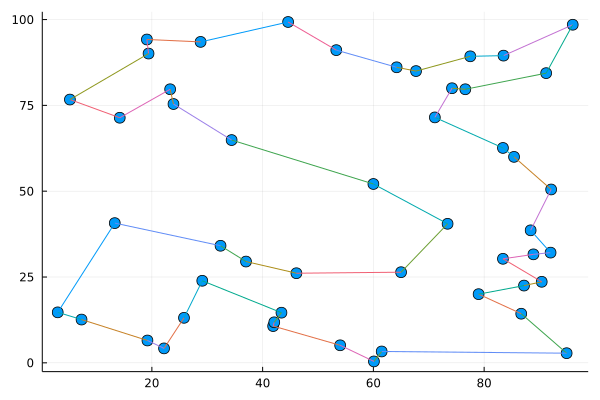

In [78]:
using JuMP
import GLPK
import Gurobi
import HiGHS
import EAGO
using BenchmarkTools
using Plots

function has_sub_tours(m, routes)
    x_val = JuMP.value.(routes)
    x_val = round.(x_val)
    x_val = Int64.(x_val)
    cycle = shortest_subtour(x_val)
    if length(cycle) <= 1
        return false
    end
    indices_to_ban = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i != j]
    @constraint(m, sum(routes[i, j] for (i,j) in indices_to_ban) <= length(cycle) -1 )
    return true
end

function display_solution(problem, route)
    x_pos = [c.x for c in problem.deliveries]
    y_pos = [c.y for c in problem.deliveries]
    plot_result = scatter(x_pos, y_pos, shape = :circle, markersize = 6)
    for i in 1:length(problem.deliveries)
        for j in 1:length(problem.deliveries)
            val = route[i, j]
            if val > 0
                del1 = problem.deliveries[i]
                del2 = problem.deliveries[j]
                plot!([del1.x, del2.x], [del1.y, del2.y], legend = false)
            end
        end
    end
    return plot_result
end;

function solve_tsp(deliveries::Int64, solver, show_viz=false)
    problem=random_instance(deliveries)
    travelmatrix = calc_travelmatrix(problem.deliveries)
    model = Model(solver)
    set_silent(model)
    # route is an adjence matrix representing a route traveled
    route=@variable(model, route[1:length(problem.deliveries), 1:length(problem.deliveries)], Bin)

    # ensure all events are planned
    @constraint(model, [i = 1:length(problem.deliveries)], sum(route[i, :]) == 1.0)
    @constraint(model, [c = 1:length(problem.deliveries)], sum(route[:, c]) == 1.0)
    # disallow traveling to itself
    @constraint(model, [j = 1:length(problem.deliveries)], route[j, j] == 0)

    traveltime = travelmatrix.* route 
    @objective(model, Min, sum(traveltime))
#     set_time_limit_sec(model, 60.0)
    optimize!(model)
    route_val = JuMP.value.(route)
    while has_sub_tours(model, route)
        optimize!(model)
        route_val = JuMP.value.(route)
    end
    if show_viz
        return display_solution(problem, route_val)
    end
end

@time solve_tsp(50, GLPK.Optimizer, true)


In [63]:
@benchmark solve_tsp(50, GLPK.Optimizer) evals=3 samples=20 seconds=3600

BenchmarkTools.Trial: 20 samples with 3 evaluations.
 Range (min … max):  1.461 s … 7.301 s  ┊ GC (min … max): 0.29% … 0.06%
 Time  (median):     2.144 s            ┊ GC (median):    0.19%
 Time  (mean ± σ):   2.759 s ± 1.606 s  ┊ GC (mean ± σ):  0.14% ± 0.08%

  █▁▁          ▁                                           
  ███▆▆▁▁▆▆▆▁▁▁█▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▆▆▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  1.46 s        Histogram: frequency by time        7.3 s <

 Memory estimate: 45.99 MiB, allocs estimate: 1854208.

In [64]:
@benchmark solve_tsp(50, Gurobi.Optimizer) evals=3 samples=20 seconds=3600

BenchmarkTools.Trial: 20 samples with 3 evaluations.
 Range (min … max):  1.498 s …    3.967 s  ┊ GC (min … max): 0.16% … 0.06%
 Time  (median):     2.286 s               ┊ GC (median):    0.20%
 Time  (mean ± σ):   2.407 s ± 635.246 ms  ┊ GC (mean ± σ):  0.15% ± 0.05%

             █ ▃              ▃                               
  ▇▇▁▁▁▁▁▇▁▇▇█▁█▁▁▁▁▁▁▁▁▁▇▇▇▁▁█▇▁▁▁▁▁▁▇▁▇▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  1.5 s          Histogram: frequency by time         3.97 s <

 Memory estimate: 36.19 MiB, allocs estimate: 1504646.

In [71]:
@benchmark solve_tsp(50, HiGHS.Optimizer) evals=3 samples=20 seconds=3600

BenchmarkTools.Trial: 20 samples with 3 evaluations.
 Range (min … max):  3.672 s … 22.751 s  ┊ GC (min … max): 0.13% … 0.03%
 Time  (median):     6.097 s             ┊ GC (median):    0.07%
 Time  (mean ± σ):   6.927 s ±  4.070 s  ┊ GC (mean ± σ):  0.06% ± 0.03%

  ▁ █   ▁▄    ▄  ▁                                          
  █▁█▁▆▆██▁▁▆▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  3.67 s        Histogram: frequency by time        22.8 s <

 Memory estimate: 47.44 MiB, allocs estimate: 1664826.

In [80]:
@benchmark solve_tsp(50, EAGO.Optimizer) evals=3 samples=20 seconds=3600

BenchmarkTools.Trial: 20 samples with 3 evaluations.
 Range (min … max):  4.042 s …    7.180 s  ┊ GC (min … max): 1.69% … 1.16%
 Time  (median):     5.826 s               ┊ GC (median):    1.42%
 Time  (mean ± σ):   5.736 s ± 893.781 ms  ┊ GC (mean ± σ):  1.57% ± 0.67%

                   ▁               █                       ▁  
  ▆▁▁▆▁▁▁▁▁▁▁▆▁▁▁▁▁█▁▁▁▁▁▁▁▆▆▆▁▆▁▁▆█▆▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▆▁▆▁▁█ ▁
  4.04 s         Histogram: frequency by time         7.18 s <

 Memory estimate: 337.28 MiB, allocs estimate: 5695500.